# Background and Context:

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.

Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.

 

# Data Description:

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

 

## Dataset:

The dataset has the following columns:

 - tweet_id                                                           
 - airline_sentiment                                               
 - airline_sentiment_confidence                               
 - negativereason                                                   
 - negativereason_confidence                                    
 - airline                                                                    
 - airline_sentiment_gold                                              
 - name     
 - negativereason_gold 
 - retweet_count
 - text
 - tweet_coord
 - tweet_created
 - tweet_location 
 - user_timezone
 

## Objective:

To analyze the dataset and make classifier models to do the sentiment analysis

In [77]:
import re, string, unicodedata                          
import contractions                                     
from bs4 import BeautifulSoup                           

import numpy as np                                     
import pandas as pd                                     
import nltk
import seaborn as sns   
import warnings
import wordcloud

nltk.download('stopwords')                              
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords  
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize  
from nltk.stem.wordnet import WordNetLemmatizer        
import matplotlib.pyplot as plt 

from sklearn.metrics import (
    make_scorer,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
   precision_recall_curve,
    roc_curve,
)
from sklearn import metrics

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


sns.set(color_codes=True) # adds a nice background to the graphs
warnings.filterwarnings("ignore")

DEFAULT_PARSER = "html.parser"
STOP_WORDS = set(wordcloud.STOPWORDS)
VERBS="v"
# Manually adding some more stop words
STOP_WORDS.add("I")
lemmatizer = WordNetLemmatizer()
RANDOM_STATE=1
DEFAULT_CLASSIFICATION_THRESHOLD = 0.5
# List of the categories
CATEGORIES = ['negative',
              'neutral',
              'positive']
NUM_FEATURES=40

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dracometallo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/dracometallo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/dracometallo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [78]:
def load_csv_file(path:str)->pd.DataFrame:
    """Load the a CSV file"""
    return pd.read_csv(path)

def print_frame_meta_info(data_frame:pd.DataFrame): 
    """Load a data frame file and print meta info of the data frame.

    Parameters
    ----------
    data_frame : DataFrame
    """
    rows,columns = np.shape(data_frame)
    print(f"Shape of the data frame is: {rows},{columns}")
    print(f"Number of variables are: {columns}")
    print("Memory Usage:"+str(data_frame.memory_usage(index=False,deep=True).sum()*0.001))
    print("")
    print("")

    
    for column in data_frame.columns:
        print(f"Name of the column: {column}")
        data_in_column = data_frame[column]
        unique_values = np.unique(data_in_column)
        print("Memory Usage:"+str(data_in_column.memory_usage()*0.001))
        num_values = len(unique_values)
        print(f"Number of unique values:{num_values}")
        if num_values<=50:
            print(f"The unique values:{unique_values}")
        print("")

def make_count_plot(col_name:str,
                    data:pd.DataFrame,
                    hue=None):
    """Make a count plot (and print info of each unique feature) for a feature in 
    a dataset."""
    fig, ax = plt.subplots()
    fig.set_size_inches(15.7, 10.27)
    ax = sns.countplot(x=col_name, data=data,hue=hue)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    plt.tight_layout()
    plt.show()
    
    if hue is None:
        print("")
        for status in data[col_name].unique():
            print(f"Number of tweets for  {status} {col_name}: {len(data[(data.get(col_name) == status)])}")

def draw_bar_plot(x,y,hue=None):
    """
    Draw bar plot for any 2 features of the table.

    x: feature x
    y: feature y
    hue: hue feature
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(15.7, 5.27)
    ax = sns.catplot(x=x,y=y,hue=hue)
    plt.tight_layout()

def plot_wordcloud(data, joined=False):
    """Plot wrod cloud for the given set of words"""
    ## If the words are already joined, then don't do it again
    if not joined:
        text = ' '.join(data.astype(str).tolist())
    else:
        text=data
    fig_wordcloud = wordcloud.WordCloud(stopwords=STOP_WORDS,background_color='white',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(14,11), frameon=True)                             
    plt.imshow(fig_wordcloud)

def remove_html_tags(data:str)->str:
    """Remove the html tags and return"""
    soup = BeautifulSoup(data, DEFAULT_PARSER)                    
    return soup.get_text()


def remove_numbers(data:str)->str:
    """Remove the numbers and return"""
    filtered_data = re.sub(r'\d+', '', data)
    return filtered_data

def remove_punctuation(data:str)->str:
    """Remove punctuation"""
    filtered_data= re.sub(r'[^\w\s]', '', data)
    return filtered_data

def remove_stopwords(words):
    """Remove stop words from list of words"""
    return [word for word in words if word not in STOP_WORDS]

def to_lowercase(words):
    """Convert the words to lower case"""
    return [word.lower() for word in words]

def lemmatize(words):
    """Lemmatize the set of words and return"""
    return [lemmatizer.lemmatize(word, pos=VERBS) for word in words]

def join_words(words):
    """Now insert space between the words and return a single string"""
    return ' '.join(words)



def print_model_performance_for_classification(model, 
                                               features, 
                                               target, 
                                               threshold=DEFAULT_CLASSIFICATION_THRESHOLD):
    """
    Print the relevant scores for a classification model

    model: the model to classify with
    features: the feature vectors
    target: our target variable to predict
    threshold: threshold to infer as belonging to lable 1.
    """
    # predicting using the independent variables
    prediction = model.predict_proba(features)[:, 1]
    prediction_threshold = prediction > threshold
    final_prediction = np.round(prediction_threshold)
    # get the scores
    accuracy = accuracy_score(target, final_prediction)   
    
    print(f"Accuracy:{accuracy}")

    
def plot_cf_matrix_with_diagnostics(y_pred,y_true):
    """Plot confusion matrix plot for a model prediction"""
    # Get the confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    cf_matrix_normalized = cf_matrix/np.sum(cf_matrix, axis=1)
    plt.figure(figsize=(12,8))
    sns.heatmap(cf_matrix_normalized, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)

def plot_import_feature_wc(features,model):
    """Plot words cloud for the important features"""
    main_features=''                                                            
    important_features=model.feature_importances_
    important_features_reversed=np.argsort(important_features)[::-1]
    for feature in important_features_reversed[0:NUM_FEATURES]:
        main_features+=features[feature]
        main_features+=' '
    plot_wordcloud(main_features,True)

In [79]:
text = ['This is the first stage of qualification'
, 'This is the second stage of qualification '
, 'And the third one'
, 'Is it the first stage again']

In [81]:
count_vec = CountVectorizer(max_features=2000)                
cv_data_features = count_vec.fit_transform(text)


In [82]:
count_vec.get_feature_names()

['again',
 'and',
 'first',
 'is',
 'it',
 'of',
 'one',
 'qualification',
 'second',
 'stage',
 'the',
 'third',
 'this']

In [100]:
text =  ['This is the first stage of qualification'
, 'This is the second stage of qualification '
, 'And the third one'
, 'Is it the first stage again']
count_vec = TfidfVectorizer(max_features=2000)                 
cv_data_features = count_vec.fit(text)
idf = count_vec.idf_

In [101]:
idf

array([1.91629073, 1.91629073, 1.51082562, 1.22314355, 1.91629073,
       1.51082562, 1.91629073, 1.51082562, 1.91629073, 1.22314355,
       1.        , 1.91629073, 1.51082562])

In [104]:
s=(dict(zip(count_vec.get_feature_names(), idf)))

In [105]:
np.min(s)

{'again': 1.916290731874155,
 'and': 1.916290731874155,
 'first': 1.5108256237659907,
 'is': 1.2231435513142097,
 'it': 1.916290731874155,
 'of': 1.5108256237659907,
 'one': 1.916290731874155,
 'qualification': 1.5108256237659907,
 'second': 1.916290731874155,
 'stage': 1.2231435513142097,
 'the': 1.0,
 'third': 1.916290731874155,
 'this': 1.5108256237659907}

In [41]:
data = load_csv_file("tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [42]:
# Let's see if the dataset has any missing value
data.isnull().sum().sort_values(ascending=False)

negativereason_gold             14608
airline_sentiment_gold          14600
tweet_coord                     13621
negativereason                   5462
user_timezone                    4820
tweet_location                   4733
negativereason_confidence        4118
tweet_created                       0
text                                0
retweet_count                       0
name                                0
airline                             0
airline_sentiment_confidence        0
airline_sentiment                   0
tweet_id                            0
dtype: int64

In [43]:
# TweetID is not needed for the analysis, hence dropping it.
data.drop(['tweet_id'],axis=1,inplace=True)

# Missing value treatment: Tweet coordinate 
- Number of missing elements for **tweet_coord** is about 93%.
- and the contents are just the longitude and latitude, not sure if it is going to help us here.
- so it is ok to be removed.

In [44]:
data.drop(['tweet_coord'],axis=1,inplace=True)

# Missing value treatment: negativereason_gold
- Number of missing elements for **negativereason_gold** is about 99%.
- and the contents are very similar to **negativereason** field.
- so it is ok to be removed.

In [45]:
data.drop(['negativereason_gold'],axis=1,inplace=True)

# Missing value treatment: name
- These are just the names of the people who tweeted this.
- Definitely not useful to keep around.

In [46]:
data.drop(['name'],axis=1,inplace=True)

# Missing value treatment: airline_sentiment_gold	
- Number of missing elements for **airline_sentiment_gold** is > 90%.
- and the contents are very similar to **airline_sentiment** field.
- so it is ok to be removed.

In [47]:
data.drop(['airline_sentiment_gold'],axis=1,inplace=True)

# Missing value treatment: negativereason, user_timezone, tweet_location and negativereason_confidence

In [48]:
data["negativereason"].fillna(data["negativereason"].mode()[0], inplace=True)
data["user_timezone"].fillna("unknown", inplace=True)
data["tweet_location"].fillna("unknown", inplace=True)
data["negativereason_confidence"].fillna(0.0, inplace=True)

# Meta of the dataset

In [49]:
print_frame_meta_info(data)

Shape of the data frame is: 14640,10
Number of variables are: 10
Memory Usage:9181.027


Name of the column: airline_sentiment
Memory Usage:117.248
Number of unique values:3
The unique values:['negative' 'neutral' 'positive']

Name of the column: airline_sentiment_confidence
Memory Usage:117.248
Number of unique values:1023

Name of the column: negativereason
Memory Usage:117.248
Number of unique values:10
The unique values:['Bad Flight' "Can't Tell" 'Cancelled Flight' 'Customer Service Issue'
 'Damaged Luggage' 'Flight Attendant Complaints' 'Flight Booking Problems'
 'Late Flight' 'Lost Luggage' 'longlines']

Name of the column: negativereason_confidence
Memory Usage:117.248
Number of unique values:1410

Name of the column: airline
Memory Usage:117.248
Number of unique values:6
The unique values:['American' 'Delta' 'Southwest' 'US Airways' 'United' 'Virgin America']

Name of the column: retweet_count
Memory Usage:117.248
Number of unique values:18
The unique values:[ 0  1  2  3  4  5 

# Exploratory Data Analysis

# Plotting the distribution of all tweets among each airline (with observations)
As seen below:
 - United airline has the most tweets
 - US airways has the second most tweets
 - American has the third most tweets
 - The least tweeted is virgin america

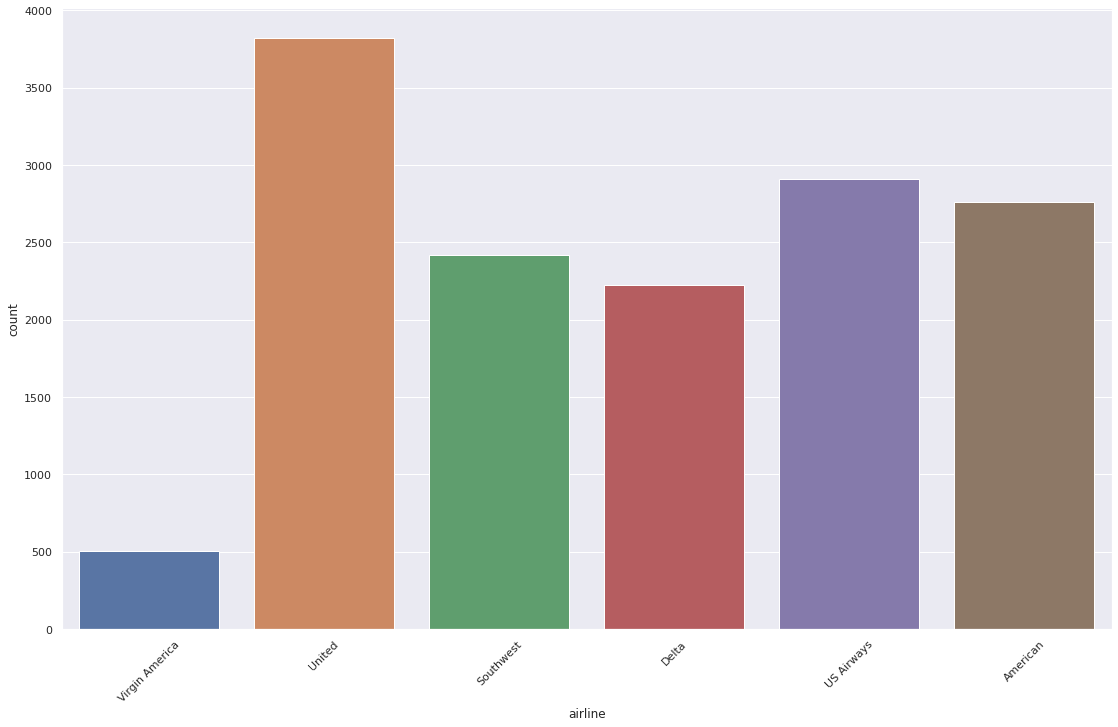


Number of tweets for  Virgin America airline: 504
Number of tweets for  United airline: 3822
Number of tweets for  Southwest airline: 2420
Number of tweets for  Delta airline: 2222
Number of tweets for  US Airways airline: 2913
Number of tweets for  American airline: 2759


In [50]:
make_count_plot(col_name="airline",data=data)

#  Plotting the distribution of sentiment across all the tweets (with observations)
As seen below:
 - Majority of the tweets are negative.
 - Minority of the tweets are positive.
 - Neutral tweets are the second highest.

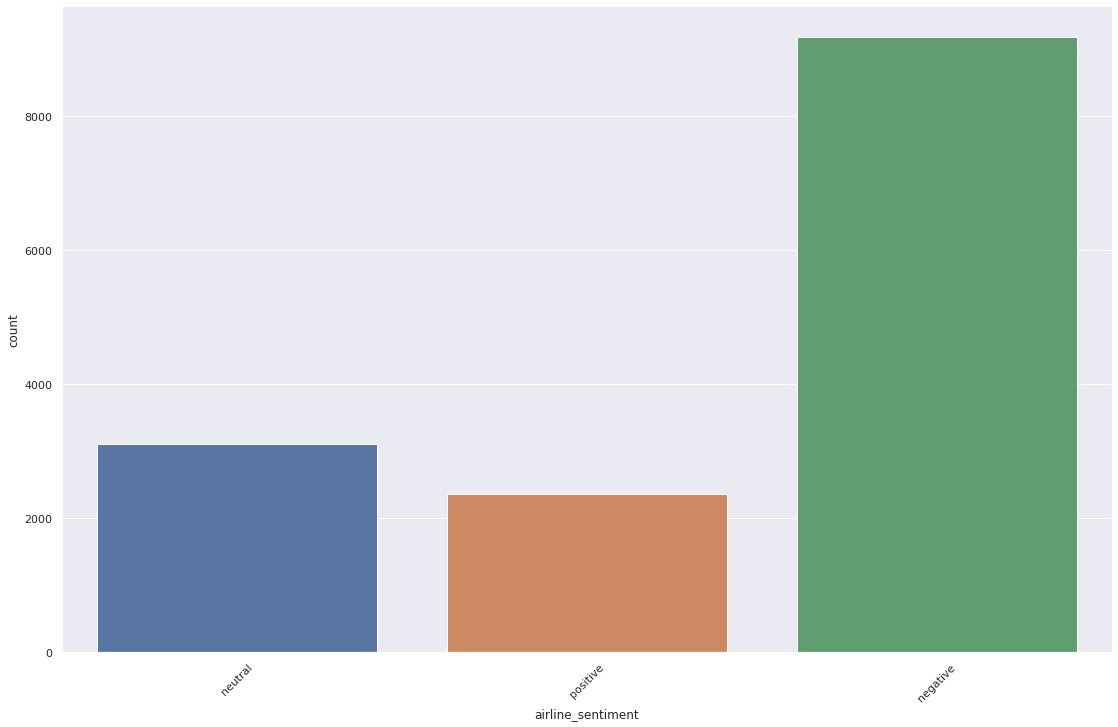


Number of tweets for  neutral airline_sentiment: 3099
Number of tweets for  positive airline_sentiment: 2363
Number of tweets for  negative airline_sentiment: 9178


In [51]:
make_count_plot(col_name="airline_sentiment",data=data)

# Plot the distribution of Sentiment of tweets for each airline (with observations)
As seen below:
 - United airlines has the most negative tweets.
 - US airways has the second most negative tweets.
 - American has the third most negative tweets.
 - Southwest has the most positive tweets.
 - Delta has the second most positive tweets.
 - virgin america has the least positive and negative tweets.

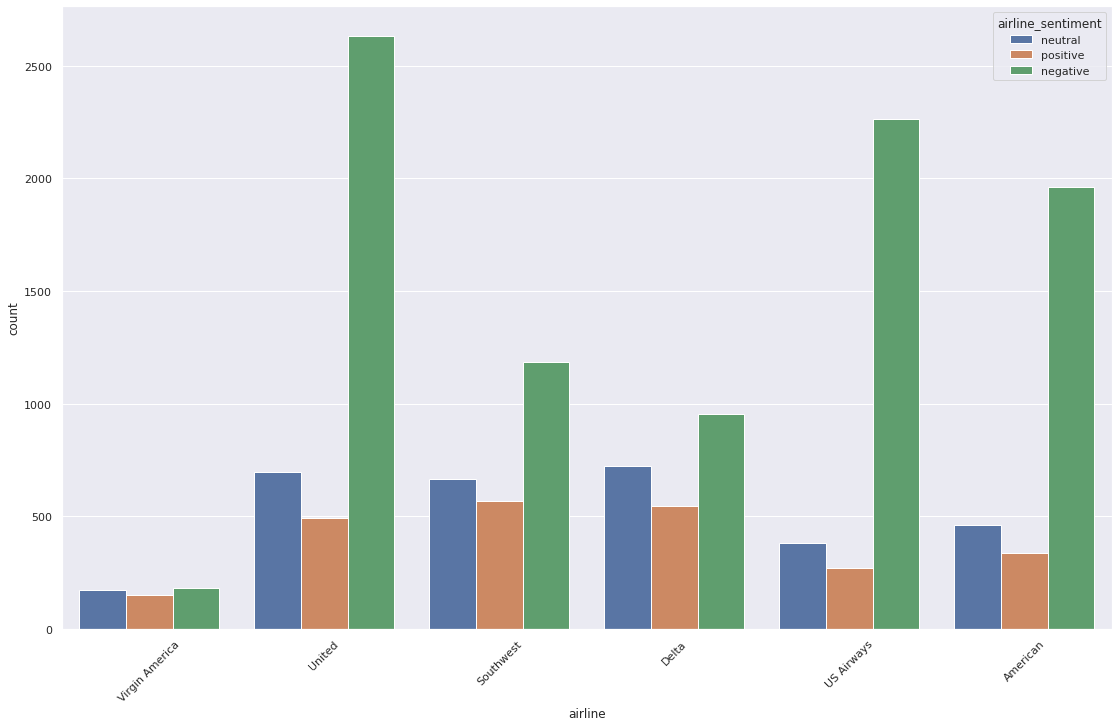

In [52]:
make_count_plot(col_name="airline",data=data,hue="airline_sentiment")

# Plot the distribution of all the negative reasons (with observations)
- Majority of the negative reasons is due to customer service issue.e
- Second highest reason for negative issue is due to late flight
- Least of the negative reasons is due to damaged luggage.

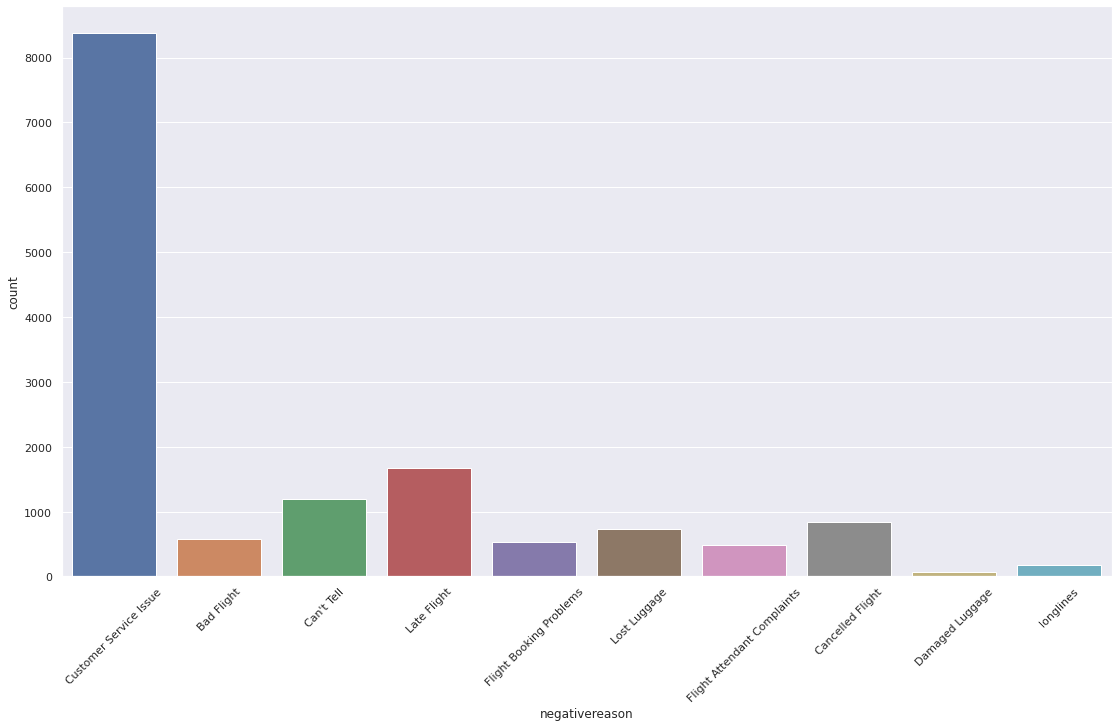


Number of tweets for  Customer Service Issue negativereason: 8372
Number of tweets for  Bad Flight negativereason: 580
Number of tweets for  Can't Tell negativereason: 1190
Number of tweets for  Late Flight negativereason: 1665
Number of tweets for  Flight Booking Problems negativereason: 529
Number of tweets for  Lost Luggage negativereason: 724
Number of tweets for  Flight Attendant Complaints negativereason: 481
Number of tweets for  Cancelled Flight negativereason: 847
Number of tweets for  Damaged Luggage negativereason: 74
Number of tweets for  longlines negativereason: 178


In [53]:
make_count_plot(col_name="negativereason",data=data)

# Plotting the word cloud graph of tweets for positive sentiment (with observations)
As seen below:
  - "Thank" word stands out, which makes sense.
  - Southwest , jetblue and virgin are there too, since they have decent positive tweets.
  - I see words like "amazing", "fantastic", "glad", "nice", "upgrade", wonderful, best and family (which makes sense), as these are positive reaction from people when their travel goes well.

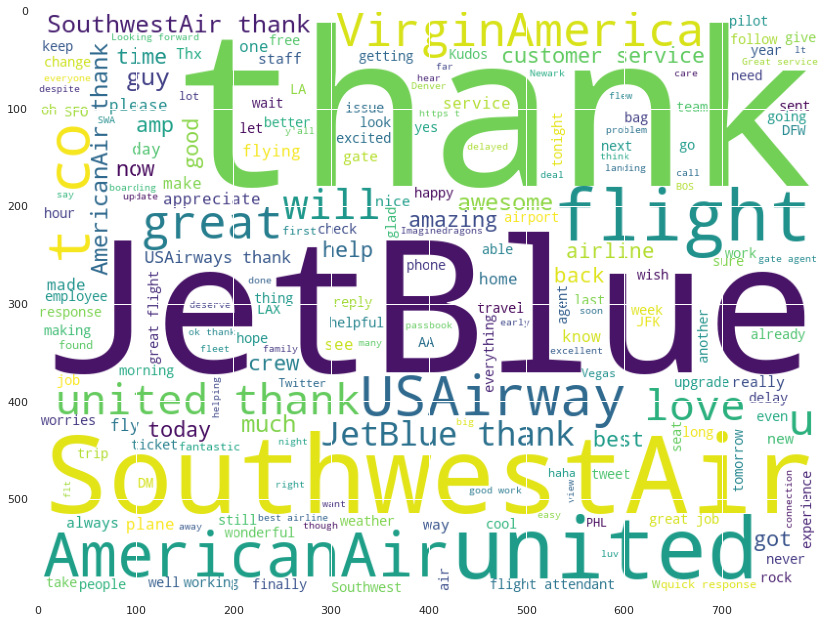

In [54]:
sentiment_dataset=data[data["airline_sentiment"]=="positive"]
plot_wordcloud(sentiment_dataset["text"])

# Plotting the word cloud graph of tweets for negative sentiment (with observations)

As seen below:
  - United is the biggest, which makes sense because it got a lot of negative tweets.
  - I see words like "cancelled flight", "late flight", delay, stuck, wait, wifi, bad,rebooked (which makes sense) as these are the negative reactions when the travel goes bad.

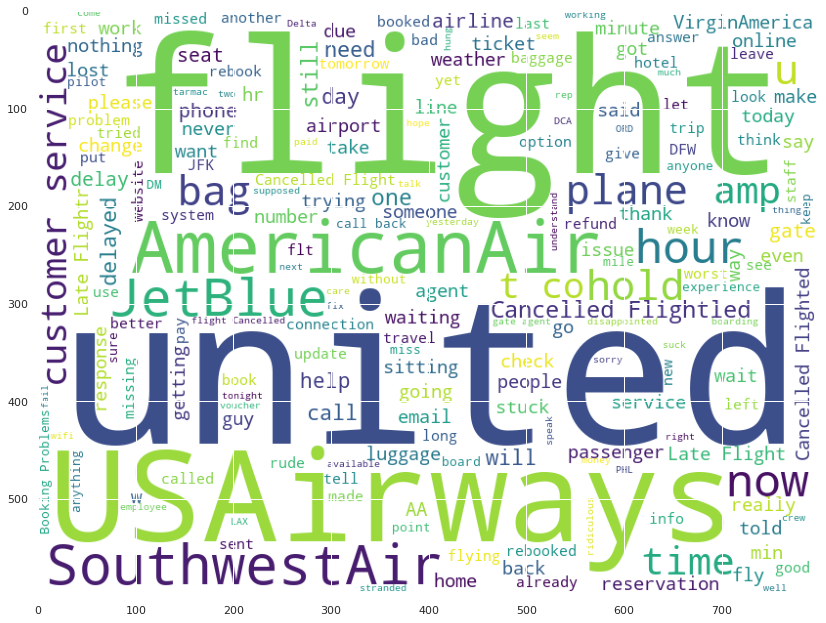

In [55]:
sentiment_dataset=data[data["airline_sentiment"]=="negative"]
plot_wordcloud(sentiment_dataset["text"])

# Plotting the word cloud graph of tweets for neutral sentiment (with observatins).
As seen below:
  - Nothing contrasting here (like it was betwene positive and negative).
  - I see overlap of some words between positive and negative here.

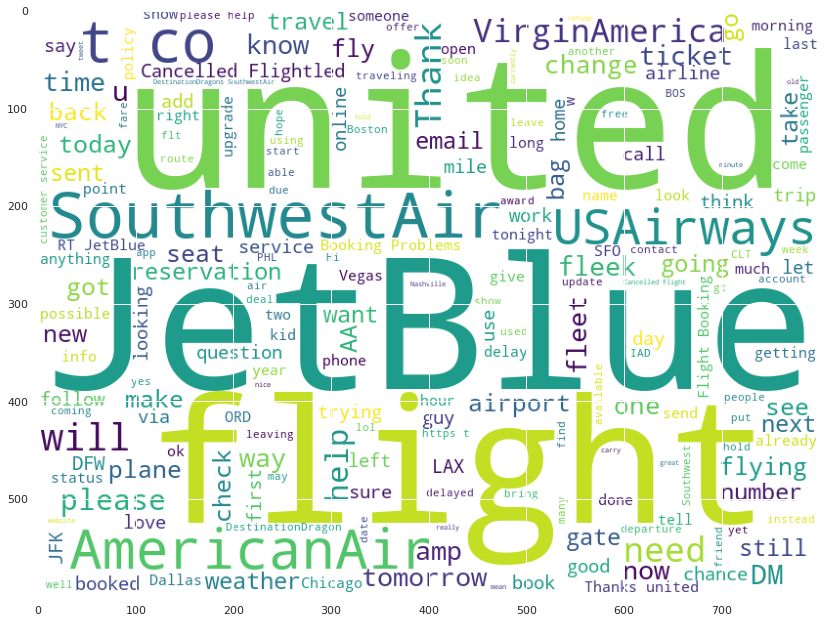

In [56]:
sentiment_dataset=data[data["airline_sentiment"]=="neutral"]
plot_wordcloud(sentiment_dataset["text"])

# Understanding of Data Columns
## Extracting just the required columns

In [57]:
sub_data = data.loc[:, ['text','airline_sentiment']]
sub_data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


# Print meta of the sub dataset

In [58]:
print_frame_meta_info(sub_data)

Shape of the data frame is: 14640,2
Number of variables are: 2
Memory Usage:3484.445


Name of the column: text
Memory Usage:117.248
Number of unique values:14427

Name of the column: airline_sentiment
Memory Usage:117.248
Number of unique values:3
The unique values:['negative' 'neutral' 'positive']



# Data Pre - Processing
## Html tag removal

In [59]:
sub_data['text'] = sub_data['text'].apply(lambda x: remove_html_tags(x))

# Remove numbers

In [60]:
sub_data['text'] = sub_data['text'].apply(lambda x: remove_numbers(x))

# Removal of Special Characters and Punctuations

In [61]:
sub_data['text'] = sub_data['text'].apply(lambda x: remove_punctuation(x)) 

# Tokenization

In [62]:
sub_data['text'] = sub_data.apply(lambda tweet: nltk.word_tokenize(tweet['text']), axis=1)

# Removal of stopwords

In [63]:
sub_data['text'] = sub_data.apply(lambda tweet: remove_stopwords(tweet['text']), axis=1)

# Conversion to lowercase

In [64]:
sub_data['text'] = sub_data.apply(lambda tweet: to_lowercase(tweet['text']), axis=1)

# Apply Lemmatization

In [65]:
sub_data['text'] = sub_data.apply(lambda tweet: lemmatize(tweet['text']), axis=1)

# Restore the text

In [66]:
sub_data['text'] = sub_data.apply(lambda tweet: join_words(tweet['text']), axis=1)

In [67]:
sub_data['text'].head()

0                      virginamerica what dhepburn say
1    virginamerica plus youve add commercials exper...
2    virginamerica didnt today must mean need take ...
3    virginamerica really aggressive blast obnoxiou...
4                   virginamerica really big bad thing
Name: text, dtype: object

# CountVectorization

In [68]:
count_vec = CountVectorizer(max_features=2000)                
cv_data_features = count_vec.fit_transform(sub_data['text'])
cv_data_features = cv_data_features.toarray()                        

# TF-IDF Vectorization

In [69]:
tf_vec = TfidfVectorizer(max_features=2000)                
tf_data_features = tf_vec.fit_transform(sub_data['text'])
tf_data_features = tf_data_features.toarray()                        

# Apply hierachial encoding and make extract the labels

In [70]:
# establish the heirachy
replaceStruct = {"airline_sentiment":{"negative":1,"neutral":2,"positive":3}}
sub_data=sub_data.replace(replaceStruct)
# Now make the labels for training.
labels = sub_data['airline_sentiment']
labels = labels.astype('int')

# Create random forest classifier  training and test set based on countvectorizer features
Accuracy score on test data for the model below is 76%.

In [71]:
# Get the training and test set from count vectorizer features.
X_train, X_test, y_train, y_test = train_test_split(cv_data_features, 
                                                    labels, 
                                                    test_size=0.3, 
                                                    random_state=RANDOM_STATE)
forest = RandomForestClassifier(n_estimators=90, 
                                n_jobs=4,
                                random_state=RANDOM_STATE)
forest = forest.fit(X_train, y_train)
print(f"CountVectizer dataset forst classifier results: Accuracy of test set: {forest.score(X_test, y_test)}")

CountVectizer dataset forst classifier results: Accuracy of test set: 0.7600182149362478


# CF matrix (as seen below) for the model above
Some observations:
  - The negative sentiments have decent prediction with around 90%.
  - The positive sentiments are ok (but not that great) at 59%.
  - Neutral sentiments have average performance around 48% (since they are hard to detect).

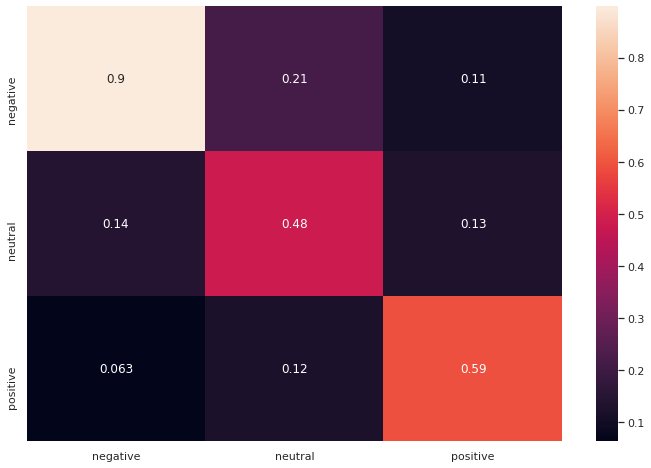

In [72]:
y_pred = forest.predict(X_test)
plot_cf_matrix_with_diagnostics(y_pred=y_pred,
                                y_true=y_test)

# Word cloud (as seen below) for Count vectorizer and the model based on it
As seen below, some of the outstanding words for the Count vectorizer and the model built off of it:
 - Thank and hour seems to pop up first to me.
 - For airlines, southwest, jetblue, virgin america and USairways are most mentioned.
 - I see words like amaze, love, great, awesome, apperciate, good and help, which will be helping a lot with the positive sentiments.
 - I see words like try, please, cant, dont and wait might be helping with negative sentiment. 

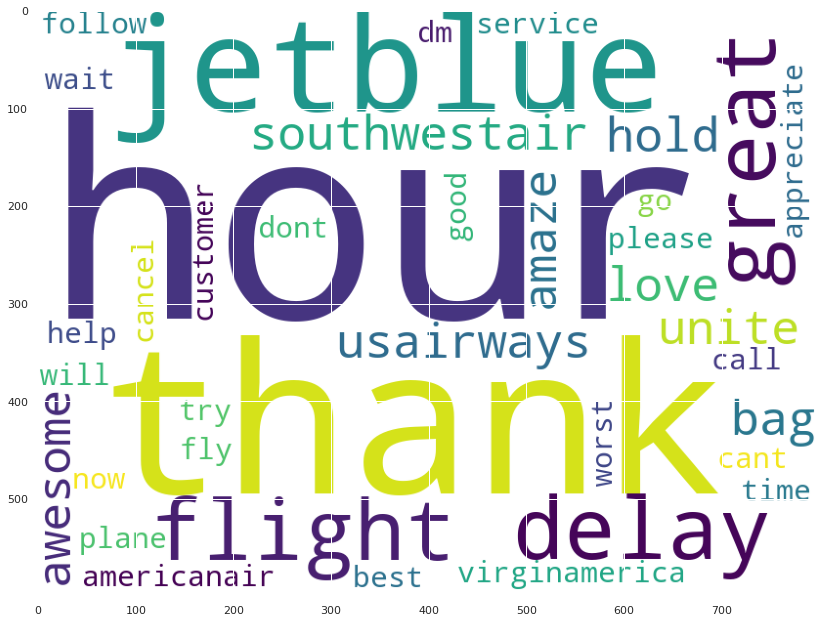

In [73]:
plot_import_feature_wc(count_vec.get_feature_names(),forest)

# Create random forest classifier training and test set based on TFIDF features

**Improving the model**:
- Using the TF-IDF features has given slight performance increase for accuracy around 76.2%(from 76%).

In [74]:
# Get the training and test set from tf-idf features.
X_train, X_test, y_train, y_test = train_test_split(tf_data_features, 
                                                    labels, 
                                                    test_size=0.3, 
                                                    random_state=RANDOM_STATE)
forest = RandomForestClassifier(n_estimators=90, 
                                n_jobs=4,
                                random_state=RANDOM_STATE)
forest = forest.fit(X_train, y_train)
print(f"TF-IDF dataset forest classifier results: Accuracy of test set: {forest.score(X_test, y_test)}")

TF-IDF dataset forest classifier results: Accuracy of test set: 0.76183970856102


# CF matrix (as seen below) for the model above
Some observations:
  - The negative sentiments have decent prediction with around 94%.
  - The positive sentiments are ok (but not great) at 54%.
  - Neutral sentiments have average performance around 40% (since they are hard to detect).

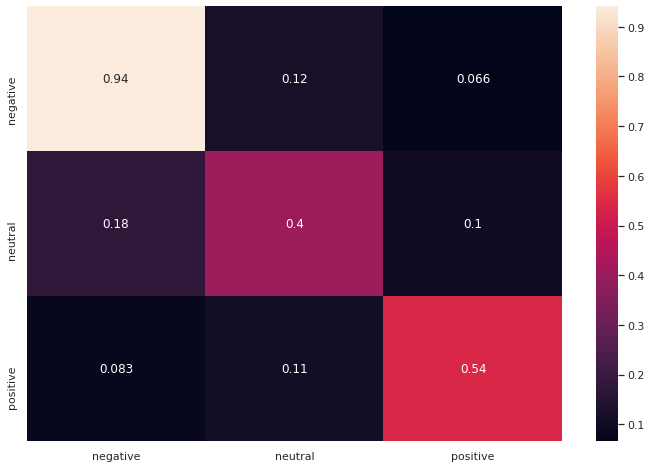

In [75]:
y_pred = forest.predict(X_test)
plot_cf_matrix_with_diagnostics(y_pred=y_pred,
                                y_true=y_test)

# Word cloud (as seen below) for TF-IDF vectorizer and the model based on it
As seen below, some of the outstanding words for the TF-IDF vectorizer and the model built off of it:
 - Thank and hour seems to pop up first to me (same as count vectorizer above)
 - For airlines, southwest, jetblue and virgin america are most mentioned.
 - I see words like best, love, great, awesome, help and good, which will be helping a lot with the positive sentiments.
 - I see words like cant, please, delay, wait, cancel might be helping with negative sentiment. 

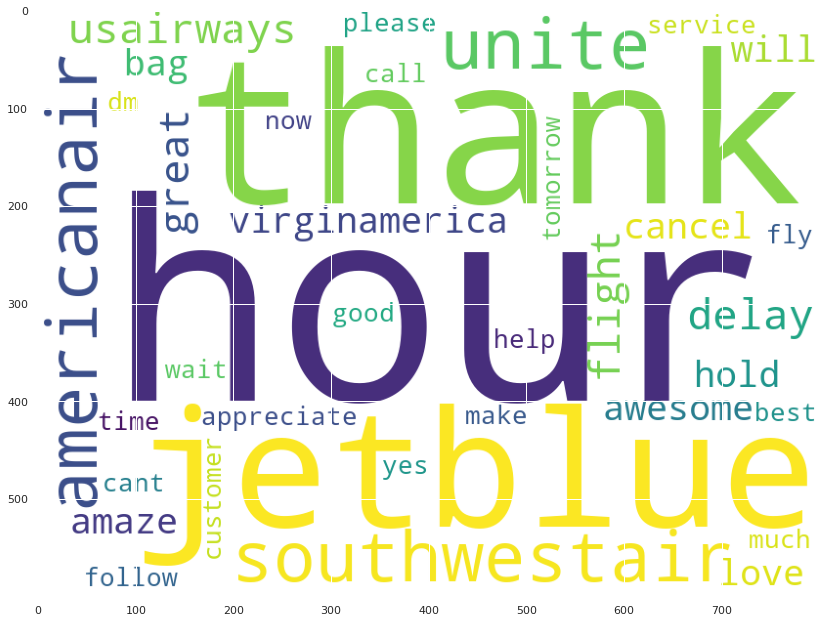

In [76]:
plot_import_feature_wc(tf_vec.get_feature_names(),forest)

# Conclusion
## Data pre processing: negative value treatment
- Initialize we inspected for missng data, which there were a lot in dataset.
- Some of the missing values like tweet coordinate, name etc were removed.
- But some features like negative reason was replaced with mode value.

## EDA - Highlights:
 - United airline has the most tweets
 - The least tweeted is virgin america
 - Majority of the tweets are negative.
 - Minority of the tweets are positive.
 - United airlines has the most negative tweets.
 - Southwest has the most positive tweets.
 - virgin america has the least positive and negative tweets.
 - Majority of the negative reasons is due to customer service issue.
 - Least of the negative reasons is due to damaged luggage.

## Data pre processing: prepping the data
The pre processing was done in the following order for this task:
 - Html tag removal: Some html tags were removed from text.
 - Remove numbers: Some numbers in the text were removed.
 - Removal of Special Characters and Punctuations: The text has special characters and punctuations, it was removed as well.
 - Tokenization: Then the text was tokenized to a list of words.
 - Removal of stop words: The stop words were removed (also added "I" in addition to default stop word).
 - conversion to lowercase: Then all the words were converted to lower case letters.
 - Lemmatization: Lemmatization was applied to all the words.

## Count vectorization and model building
- Count vectorization was applied on the dataset
- A forest classifier model was build on it.
- And that yielded 76% accuracy.
- Based on confusion matrix:
   - The negative sentiments have decent prediction with around 90%.
   - The positive sentiments are ok (but not that great) at 59%.
   - Neutral sentiments have average performance around 48% (since they are hard to detect).
   
## TFIDF vectorization and model building
- TF-IDF vectorization was applied on the dataset
- A forest classifier model was build on it.
- And that yielded 76.2% accuracy.
- Based on confusion matrix:
    - The negative sentiments have decent prediction with around 94%.
    - The positive sentiments are ok (but not great) at 54%.
    - Neutral sentiments have average performance around 40% (since they are hard to detect).

## which model should we use?
- Both the model have >75% accuracy.
- But the **TF-IDF based model** have slighlty better accuracy. So let's use that.
- Also before applying the model:
   - Please apply preprocessing steps (as done here)
   - Apply the TF-IDF vectorizer and then do the prediction.